# **Лабораторная работа № 5. Обучение и тестирование модели**


# Установка библиотек

In [134]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.graph_objs as go
from plotly.offline import iplot

device = "cpu"

# Загрузка набора данных

In [135]:
df = pd.read_csv("dataset.csv").iloc[:, :2]
df.columns = ["Date", "Temperature"]
df = df.set_index('Date')

df.index = pd.to_datetime(df.index)
if not df.index.is_monotonic:
    df = df.sort_index()

df


<ipython-input-135-a7e2954cfbcb>:6: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



,Temperature
Date,
2008-01-12,-20
2008-01-13,-9
2008-01-14,-6
2008-01-15,-1
2008-01-17,-4
...,...
2023-09-26,21
2023-09-27,19
2023-09-28,18


# Визуализация датасета

In [136]:
def plot_dataset(df: pd.DataFrame, title: str) -> None:
    data = []

    value = go.Scatter(
        x=df.index,
        y=df.Temperature,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Temperature", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

plot_dataset(df, "Изменение температуры")

# Генерация наблюдений с задержкой по времени

In [137]:
def generate_time_lags(df: pd.DataFrame, n_lags: int) -> pd.DataFrame:
    """Generation of observations with a time delay"""
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["Temperature"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

input_dim = 100

df_timelags = generate_time_lags(df, input_dim)
df_timelags

<ipython-input-137-88e2f781241c>:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



,Temperature,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag91,lag92,lag93,lag94,lag95,lag96,lag97,lag98,lag99,lag100
Date,,,,,,,,,,,,,,,,,,,,,
2008-04-25,13,4.0,9.0,18.0,19.0,15.0,12.0,12.0,11.0,8.0,...,-9.0,-13.0,-15.0,-9.0,-8.0,-4.0,-1.0,-6.0,-9.0,-20.0
2008-04-26,16,13.0,4.0,9.0,18.0,19.0,15.0,12.0,12.0,11.0,...,-11.0,-9.0,-13.0,-15.0,-9.0,-8.0,-4.0,-1.0,-6.0,-9.0
2008-04-27,14,16.0,13.0,4.0,9.0,18.0,19.0,15.0,12.0,12.0,...,-8.0,-11.0,-9.0,-13.0,-15.0,-9.0,-8.0,-4.0,-1.0,-6.0
2008-04-28,15,14.0,16.0,13.0,4.0,9.0,18.0,19.0,15.0,12.0,...,-4.0,-8.0,-11.0,-9.0,-13.0,-15.0,-9.0,-8.0,-4.0,-1.0
2008-04-29,17,15.0,14.0,16.0,13.0,4.0,9.0,18.0,19.0,15.0,...,-1.0,-4.0,-8.0,-11.0,-9.0,-13.0,-15.0,-9.0,-8.0,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-26,21,25.0,26.0,26.0,25.0,24.0,19.0,19.0,22.0,23.0,...,22.0,20.0,20.0,17.0,16.0,16.0,17.0,15.0,20.0,28.0
2023-09-27,19,21.0,25.0,26.0,26.0,25.0,24.0,19.0,19.0,22.0,...,24.0,22.0,20.0,20.0,17.0,16.0,16.0,17.0,15.0,20.0
2023-09-28,18,19.0,21.0,25.0,26.0,26.0,25.0,24.0,19.0,19.0,...,23.0,24.0,22.0,20.0,20.0,17.0,16.0,16.0,17.0,15.0


# Разделение данных на тестовые, проверочные и обучающие наборы.

In [138]:
from sklearn.model_selection import train_test_split

def feature_label_split(df: pd.DataFrame, target_col: str) -> tuple[pd.DataFrame]:
    """Separation of validation and training sets"""
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_val_test_split(df: pd.DataFrame, target_col: str, test_ratio: float) -> tuple[pd.DataFrame]:
    """Separation of validation and training sets"""
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_timelags, 'Temperature', 0.2)

# Применение преобразования масштаба

In [139]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler: str):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [140]:
scaler = get_scaler('minmax')
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

# Загрузка данных в DataLoaders

In [141]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

# Модель RNN

In [142]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        """The __init__ method that initiates an RNN instance.

        Args:
            input_dim (int): The number of nodes in the input layer
            hidden_dim (int): The number of nodes in each layer
            layer_dim (int): The number of layers in the network
            output_dim (int): The number of nodes in the output layer
            dropout_prob (float): The probability of nodes being dropped out

        """
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

# Вспомогательный класс-оболочка для обучения

In [143]:
class Optimization:
    """Optimization is a helper class that allows training, validation, prediction.

    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    Attributes:
        model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
        loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
        optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        train_losses (list[float]): The loss values from the training
        val_losses (list[float]): The loss values from the validation
        last_epoch (int): The number of epochs that the models is trained
    """
    def __init__(self, model, loss_fn, optimizer):
        """
        Args:
            model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
            loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
            optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        """
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []

    def train_step(self, x, y):
        """The method train_step completes one step of training.

        Given the features (x) and the target values (y) tensors, the method completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        Args:
            x (torch.Tensor): Tensor for features to train one step
            y (torch.Tensor): Tensor for target values to calculate losses

        """
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=100, n_features=1):
        """The method train performs the model training

        The method takes DataLoaders for training and validation datasets, batch size for
        mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the method train_step for
        n_epochs times. If early stopping is enabled, then it  checks the stopping condition
        to decide whether the training needs to halt before n_epochs steps. Finally, it saves
        the model in a designated file path.

        Args:
            train_loader (torch.utils.data.DataLoader): DataLoader that stores training data
            val_loader (torch.utils.data.DataLoader): DataLoader that stores validation data
            batch_size (int): Batch size for mini-batch training
            n_epochs (int): Number of epochs, i.e., train steps, to train
            n_features (int): Number of feature columns

        """
        model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """The method evaluate performs the model evaluation

        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        Args:
            test_loader (torch.utils.data.DataLoader): DataLoader that stores test data
            batch_size (int): Batch size for mini-batch training
            n_features (int): Number of feature columns

        Returns:
            list[float]: The values predicted by the model
            list[float]: The actual values in the test set.

        """
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values

    def plot_losses(self):
        """The method plots the calculated loss values for training and validation"""
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

# Обучение модели

[1/20] Training loss: 0.0397	 Validation loss: 0.0053
[2/20] Training loss: 0.0110	 Validation loss: 0.0056
[3/20] Training loss: 0.0092	 Validation loss: 0.0049
[4/20] Training loss: 0.0085	 Validation loss: 0.0047
[5/20] Training loss: 0.0085	 Validation loss: 0.0065
[6/20] Training loss: 0.0103	 Validation loss: 0.0130
[7/20] Training loss: 0.0099	 Validation loss: 0.0046
[8/20] Training loss: 0.0073	 Validation loss: 0.0055
[9/20] Training loss: 0.0070	 Validation loss: 0.0052
[10/20] Training loss: 0.0111	 Validation loss: 0.0059


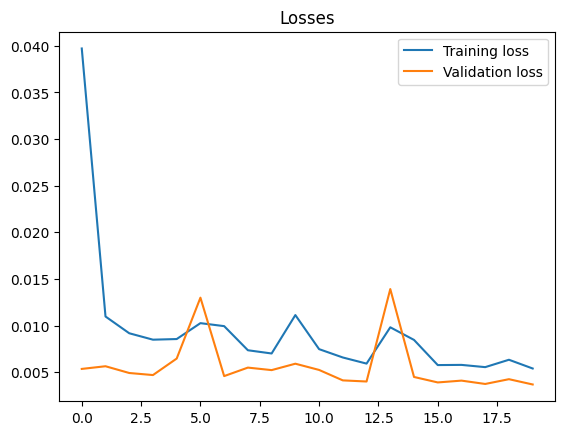

In [144]:
import torch.optim as optim

input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 20
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = RNNModel(**model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

# Форматирование прогнозов

In [145]:
def inverse_transform(scaler, df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """Get the real values of the forecasts."""
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions: list, values: list, df_test: pd.DataFrame, scaler) -> pd.DataFrame:
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


df_result = format_predictions(predictions, values, X_test, scaler)
df_result

,value,prediction
Date,,
2020-09-06,21.000000,18.921326
2020-09-07,25.000002,19.781218
2020-09-08,27.000000,20.776863
2020-09-09,11.999999,21.730949
2020-09-10,17.000000,18.426474
...,...,...
2023-09-26,21.000000,21.340651
2023-09-27,19.000002,21.199373
2023-09-28,17.999998,19.345741


# Расчет показателей ошибок

In [146]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df: pd.DataFrame) -> dict:
    """Calculate error metrics such as mean absolute error, standard error, and standard error"""
    result_metrics = {'mae' : mean_absolute_error(df.value, df.prediction),
                      'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
                      'r2' : r2_score(df.value, df.prediction)}

    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])
    return result_metrics

result_metrics = calculate_metrics(df_result)

Mean Absolute Error:        3.4408505
Root Mean Squared Error:    4.249213875264371
R^2 Score:                  0.9111071714213206


# Визуализация прогнозов

In [147]:
def get_temp_by_month(df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    """Getting the temperature in the specified period"""
    df = df.reset_index(inplace=False)
    start_date = pd.to_datetime(start_date, format='%Y-%m-%d')
    end_date = pd.to_datetime(end_date, format='%Y-%m-%d')
    return df[(start_date <= df["Date"]) & (df["Date"] <= end_date)]

get_temp_by_month(df_result, "2023-01-10", "2023-01-21")

,Date,value,prediction
836,2023-01-10,-23.000000,-18.291405
837,2023-01-11,-21.000000,-19.296722
838,2023-01-12,-15.000000,-18.124058
839,2023-01-13,-14.000000,-16.111074
840,2023-01-14,-12.000000,-14.507428
841,2023-01-15,-10.000001,-13.322004
842,2023-01-16,-12.000000,-12.008971
843,2023-01-17,-12.000000,-12.951898
844,2023-01-18,-10.000001,-12.423480
845,2023-01-19,-8.999999,-12.020812


<Axes: xlabel='Date'>

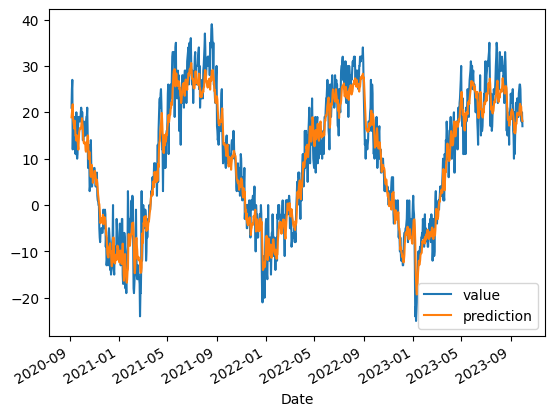

In [148]:
df_result.plot()